In [1]:
import os
import glob
from datetime import datetime
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from cmocean import cm
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, ConfusionMatrixDisplay
from scipy.interpolate import RectBivariateSpline, RegularGridInterpolator
from scipy.ndimage import zoom

from zarr_file import ZarrFile
from collocate_snapshots import Collocator


def sigmoid(x, k, x0):
    return (1 / (1 + np.exp(-k * (x - x0))) - 1 / (1 + np.exp(-k * (0 - x0)))) / (1 / (1 + np.exp(-k * (1 - x0))) - 1 / (1 + np.exp(-k * (0 - x0))))


In [2]:
rrdp_dir = '../SAGE_RRDP/s_rrdp_v01_fv01/'
rrdp_template_file = '20120102_N_v01_fv01.nc'
lmsiage_file = '../../sea_ice_age/mesh_arctic_ease_25km_max7.npz'
lmsiage_dir = 'grid'
newdc_dir = 'outputs'
output_dir = './collocated/'
nsidc_dir = '../NSIDC_iceage/'
self = Collocator(rrdp_dir=rrdp_dir, rrdp_template_file=rrdp_template_file, lmsiage_file=lmsiage_file, lmsiage_dir=lmsiage_dir, newdc_dir=newdc_dir, nsidc_dir=nsidc_dir, output_dir=output_dir)
self.read_template_file()
self.resample_lmsiage_masks()


In [4]:
lmsiage_file = 'grid/2012/grid_20121231.zip'
mf = ZarrFile(lmsiage_file)
names = mf.read_names()
data = mf.load()
data.keys()

dst = {}
for key in data:
    rgi = RegularGridInterpolator((self.lmsiage_yc, self.lmsiage_xc), data[key], method='nearest', bounds_error=False, fill_value=0)
    a_dst = rgi(self.dst_grids).reshape(self.dst_y.size, self.dst_x.size)
    a_dst[self.mask_dst.data != 1] = np.nan
    #a_dst[self.landmask_ldst.data == 1] = -2
    dst[key] = a_dst

print(dst.keys())

dict_keys(['unc_7yi', 'sic_6yi', 'age', 'sic_5yi', 'unc_2yi', 'unc_1yi', 'unc_age', 'sic_2yi', 'unc_4yi', 'sic_3yi', 'unc_6yi', 'unc_3yi', 'sic_1yi', 'sic_4yi', 'sic_7yi', 'unc_5yi'])


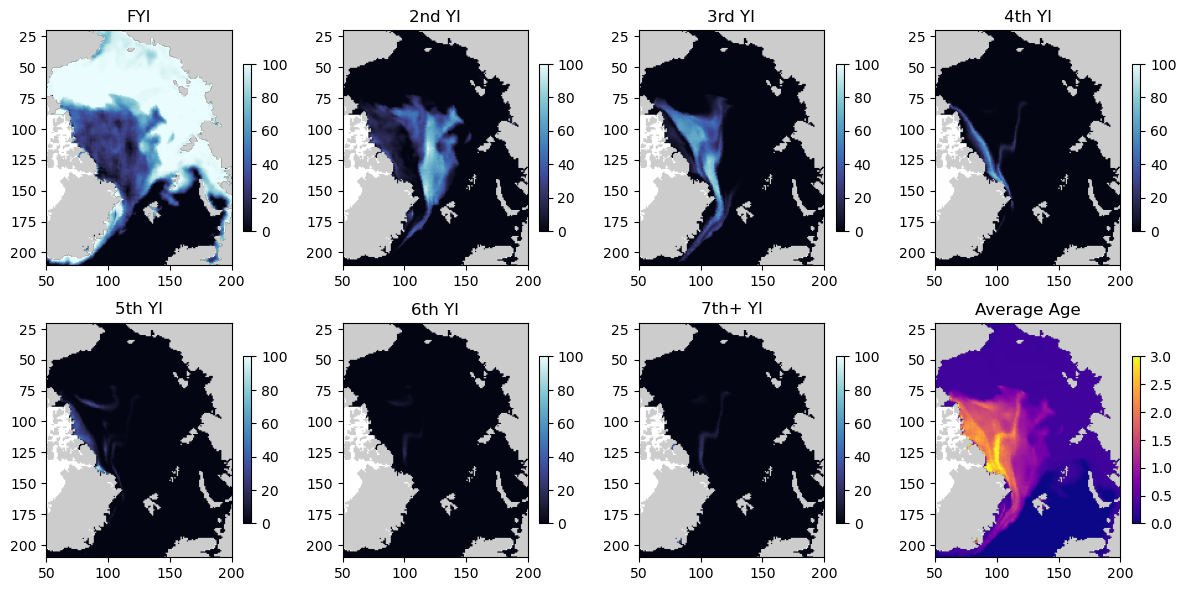

In [5]:
titles = ['FYI', '2nd YI', '3rd YI', '4th YI', '5th YI', '6th YI', '7th+ YI', 'Average Age']
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(7):
    name = f'sic_{i+1}yi'
    im = axs.flat[i].imshow(dst[name], vmin=0, vmax=100, cmap=cm.ice)
    fig.colorbar(im, ax=axs.flat[i], shrink=0.7)
    axs.flat[i].imshow(self.landmask_ldst, alpha=0.2, cmap=cm.gray)

im = axs.flat[7].imshow(dst['age'], vmin=0, vmax=3, cmap='plasma')
fig.colorbar(im, ax=axs.flat[7], shrink=0.7)
axs.flat[7].imshow(self.landmask_ldst, alpha=0.2, cmap=cm.gray)
for ax, title in zip(axs.flat, titles):
    ax.set_title(title)
    ax.set_xlim(50, 200)
    ax.set_ylim(210, 20)
plt.tight_layout()
plt.show()

In [6]:
max_age = {}
#LM
concs = np.dstack([dst[f'sic_{i+1}yi'] for i in range(7)])
max_age['LM'] = np.zeros_like(concs[:,:,0])
for i in range(7):
    max_age['LM'][concs[:,:,i] > 15] = i + 1
max_age['LM'][self.mask_dst.data != 1] = np.nan

# NSIDC1
newdc_file = 'outputs/2012/12/newdc_age_20121231.zip'
age, = ZarrFile(newdc_file).load(['age'], as_dict=False)
rgi = RegularGridInterpolator((self.lmsiage_yc2, self.lmsiage_xc2), age, method='nearest', bounds_error=False, fill_value=0)
max_age['N1'] = rgi(self.dst_grids).reshape(self.dst_y.size, self.dst_x.size)
max_age['N1'][self.mask_dst.data != 1] = np.nan

# NSIDC2
date = datetime(2012, 12, 31)
ncidc_file = 'NSIDC_iceage/iceage_nh_12.5km_20120101_20121231_v4.1.nc'
if not hasattr(self, 'nsidc_file') or self.nsidc_file != ncidc_file:
    print(f'Loading NSIDC SIAge file: {ncidc_file}')
    with xr.open_dataset(ncidc_file) as ds:
        self.ds_x = ds.x.values
        self.ds_y = ds.y.values
        self.ds_sia = ds.age_of_sea_ice.values # 20 - land mask, 21 - no data
    self.nsidc_file = ncidc_file
week_index = min((date - datetime(date.year, 1, 1)).days // 7, self.ds_sia.shape[0] - 1)
rgi = RegularGridInterpolator((self.ds_y[::-1], self.ds_x), self.ds_sia[week_index], method='nearest', bounds_error=False, fill_value=0)
max_age['N2'] = rgi(self.dst_grids).reshape(self.dst_y.size, self.dst_x.size).astype(float)
max_age['N2'][max_age['N2'] >= 20] = np.nan

Loading NSIDC SIAge file: NSIDC_iceage/iceage_nh_12.5km_20120101_20121231_v4.1.nc


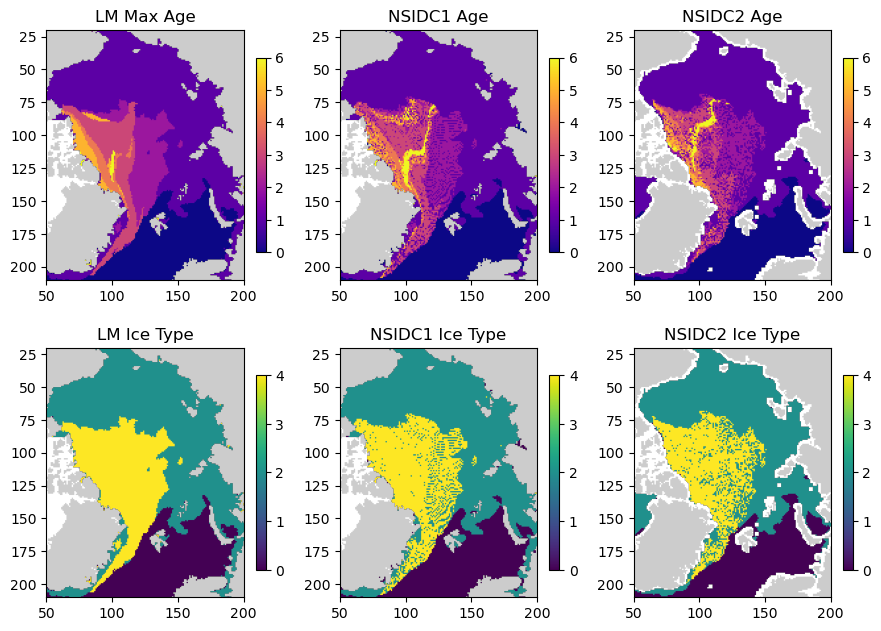

In [7]:
ice_type = {}
for algo in max_age:
    ice_type[algo] = np.full(max_age[algo].shape, np.nan)
    ice_type[algo][max_age[algo] == 0] = 0
    ice_type[algo][max_age[algo] > 1] = 4
    ice_type[algo][max_age[algo] == 1] = 2


titles = ['LM Max Age', 'NSIDC1 Age', 'NSIDC2 Age', 'LM Ice Type', 'NSIDC1 Ice Type', 'NSIDC2 Ice Type']
clim = [0, 6]
fig, axs = plt.subplots(2, 3, figsize=(9, 6.5))
axs[0, 0].imshow(max_age['LM'], cmap='plasma', clim=clim)
axs[0, 1].imshow(max_age['N1'], cmap='plasma', clim=clim)
axs[0, 2].imshow(max_age['N2'], cmap='plasma', clim=clim)
axs[1, 0].imshow(ice_type['LM'], cmap='viridis')
axs[1, 1].imshow(ice_type['N1'], cmap='viridis')
axs[1, 2].imshow(ice_type['N2'], cmap='viridis')

for ax, title in zip(axs.flat, titles):
    ax.imshow(self.landmask_ldst, alpha=0.2, cmap=cm.gray)
    ax.set_title(title)
    ax.set_xlim(50, 200)
    ax.set_ylim(210, 20)
    fig.colorbar(ax.images[0], ax=ax, shrink=0.7)
plt.tight_layout()
plt.show()

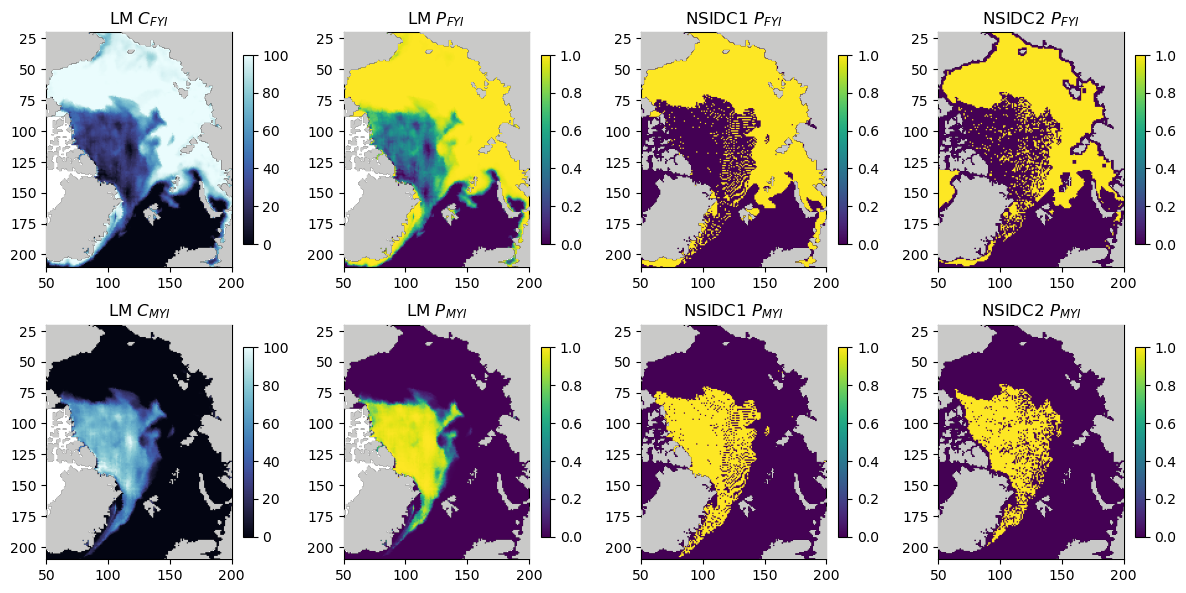

In [8]:
# from comparison of ice charts:
x0_fyi = 0.263
k_fyi = 6.58
x0_myi = 0.423
k_myi = 11.3

lm_fyi_conc = concs[:, :, 0]
lm_myi_conc = concs[:, :, 1:].sum(axis=2)
lm_fyi_proba = sigmoid(lm_fyi_conc / 100, k_fyi, x0_fyi)
lm_myi_proba = sigmoid(lm_myi_conc / 100, k_myi, x0_myi)

titles = [
    'LM $C_{FYI}$', 'LM $P_{FYI}$', 'NSIDC1 $P_{FYI}$', 'NSIDC2 $P_{FYI}$',
    'LM $C_{MYI}$', 'LM $P_{MYI}$', 'NSIDC1 $P_{MYI}$', 'NSIDC2 $P_{MYI}$',
]

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs[0, 0].imshow(lm_fyi_conc, cmap=cm.ice, clim=[0, 100])
axs[1, 0].imshow(lm_myi_conc, cmap=cm.ice, clim=[0, 100])
axs[0, 1].imshow(lm_fyi_proba, clim=[0, 1])
axs[1, 1].imshow(lm_myi_proba, clim=[0, 1])
axs[0, 2].imshow(ice_type['N1']==2, clim=[0, 1])
axs[1, 2].imshow(ice_type['N1']==4, clim=[0, 1])
axs[0, 3].imshow(ice_type['N2']==2, clim=[0, 1])
axs[1, 3].imshow(ice_type['N2']==4, clim=[0, 1])


for ax, title in zip(axs.flat, titles):
    ax.imshow(self.landmask_ldst, alpha=1, cmap=cm.gray, zorder=10, clim=[0, 1.2])
    ax.set_title(title)
    ax.set_xlim(50, 200)
    ax.set_ylim(210, 20)
    fig.colorbar(ax.images[0], ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()